In [9]:
# Environment: micasa

In [10]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import holoviews as hv
# hv.extension('bokeh')
import hvplot.xarray
import hvplot.pandas
from bokeh.models import DatetimeTickFormatter
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import datetime
# import whenever 
import glob
import os
import pytz
# from timezonefinder import TimezoneFinder

In [ ]:
# Define misc variables
amer_filepath = 'ameriflux-data/'
mic_filepath = 'intermediates/'
timedelta = 'DD'

In [ ]:
# Define site ID (make this input for .py script)
site_ID = 'US-Ne1'

In [12]:
# Import site metadata csv
meta_file = amer_filepath + 'AmeriFlux-site-search-results-202410071335.tsv'
ameriflux_meta = pd.read_csv(meta_file, sep='\t')
fluxnet_meta = ameriflux_meta.loc[ameriflux_meta['AmeriFlux FLUXNET Data'] == 'Yes'] #use FLUXNET only

In [13]:
# Define a single match file location function
def get_single_match(pattern):
    matches = glob.glob(pattern)
    if len(matches) == 1:
        return matches[0]
    elif len(matches) == 0:
        raise ValueError(f"No matches found")
    else:
        raise ValueError(f"Multiple matches found: {matches}")

In [ ]:
# Function to plot data (no widget)
def hv_plot_data(dataset):
    # Define misc plotting variables
    datetimeformatter = DatetimeTickFormatter(
    hours='%H:%M',
    days='%m/%d %H:%M',
    months='%b %Y',
    )
    # months='%b %Y %H:%M')

    plot = dataset.hvplot(
        width=1200,height=500,
        label='Fluxnet',
        xlabel='time',
        xformatter= datetimeformatter,
        yformatter='%.1e',
        ylabel = 'NEE (kg C m-2 s-1)',
        title = f'{site_ID} (Daily Averages)',
        legend='bottom',
        grid=True,
    ).opts(legend_position='bottom_left')
    return plot

## Import FluxNet Data

In [29]:
# Import selected site daily subset data
site_lat = fluxnet_meta.loc[fluxnet_meta['Site ID'] == site_ID, 'Latitude (degrees)'].values
site_lon = fluxnet_meta.loc[fluxnet_meta['Site ID'] == site_ID, 'Longitude (degrees)'].values

sel_file = get_single_match(amer_filepath + 'AMF_' + site_ID + '_FLUXNET_SUBSET_*/AMF_' + site_ID + '_FLUXNET_SUBSET_' + timedelta + '_*.csv')
fluxnet_sel = pd.read_csv(sel_file)
print(list(fluxnet_sel.columns))

['TIMESTAMP', 'TA_F', 'TA_F_QC', 'SW_IN_POT', 'SW_IN_F', 'SW_IN_F_QC', 'LW_IN_F', 'LW_IN_F_QC', 'VPD_F', 'VPD_F_QC', 'PA_F', 'PA_F_QC', 'P_F', 'P_F_QC', 'WS_F', 'WS_F_QC', 'USTAR', 'USTAR_QC', 'NETRAD', 'NETRAD_QC', 'SW_OUT', 'SW_OUT_QC', 'LW_OUT', 'LW_OUT_QC', 'CO2_F_MDS', 'CO2_F_MDS_QC', 'TS_F_MDS_1', 'TS_F_MDS_2', 'TS_F_MDS_3', 'TS_F_MDS_4', 'TS_F_MDS_5', 'TS_F_MDS_6', 'TS_F_MDS_7', 'TS_F_MDS_8', 'TS_F_MDS_1_QC', 'TS_F_MDS_2_QC', 'TS_F_MDS_3_QC', 'TS_F_MDS_4_QC', 'TS_F_MDS_5_QC', 'TS_F_MDS_6_QC', 'TS_F_MDS_7_QC', 'TS_F_MDS_8_QC', 'SWC_F_MDS_1', 'SWC_F_MDS_2', 'SWC_F_MDS_3', 'SWC_F_MDS_4', 'SWC_F_MDS_1_QC', 'SWC_F_MDS_2_QC', 'SWC_F_MDS_3_QC', 'SWC_F_MDS_4_QC', 'G_F_MDS', 'G_F_MDS_QC', 'LE_F_MDS', 'LE_F_MDS_QC', 'LE_CORR', 'LE_CORR_25', 'LE_CORR_75', 'LE_RANDUNC', 'H_F_MDS', 'H_F_MDS_QC', 'H_CORR', 'H_CORR_25', 'H_CORR_75', 'H_RANDUNC', 'NEE_VUT_REF', 'NEE_VUT_REF_QC', 'NEE_VUT_REF_RANDUNC', 'NEE_VUT_25', 'NEE_VUT_50', 'NEE_VUT_75', 'NEE_VUT_25_QC', 'NEE_VUT_50_QC', 'NEE_VUT_75_QC', '

In [ ]:
# select subset of columns + convert to datetime objects    
fluxnet_sel_sub = fluxnet_sel.loc[:,['TIMESTAMP','NEE_VUT_REF','NEE_VUT_REF_QC','GPP_NT_VUT_REF', 'GPP_DT_VUT_REF']].copy()
fluxnet_sel_sub['TIMESTAMP'] = pd.to_datetime(fluxnet_sel_sub['TIMESTAMP'],format='%Y%m%d')
fluxnet_sel_sub = fluxnet_sel_sub.set_index('TIMESTAMP')

# Print raw data
fluxnet_sel_sub

,NEE_VUT_REF,NEE_VUT_REF_QC,GPP_NT_VUT_REF,GPP_DT_VUT_REF
TIMESTAMP,,,,
2001-01-01,1.724590,0.000000,-1.592180,3.88356
2001-01-02,1.449880,0.000000,-1.218270,4.37163
2001-01-03,1.580190,0.000000,-0.922631,4.54447
2001-01-04,1.724590,0.000000,-0.926978,4.33976
2001-01-05,1.449880,0.000000,-0.636165,4.60081
...,...,...,...,...
2020-12-27,0.994410,1.000000,0.111116,0.00000
2020-12-28,0.709396,1.000000,0.187705,0.00000
2020-12-29,0.693536,1.000000,0.619703,0.00000


In [50]:
# Check micasa units:
micasa_test = xr.open_dataset(get_single_match('micasa-data/daily-0.1deg-final/holding/daily/2024/01/MiCASA_v1_flux*20240101.nc4'))
micasa_test['NEE'].units, micasa_test['NPP'].units

('kg m-2 s-1', 'kg m-2 s-1')

In [73]:
# Make a clean output df
fluxnet_final = pd.DataFrame()

# NEE
## Convert units
## FluxNet NEE_VUT_REF in DD (gC m-2 d-1) to MiCASA (kgC m-2 s-1)
fluxnet_final['NEE (kgC m-2 s-1)'] = fluxnet_sel_sub['NEE_VUT_REF']*1e-3/86400

## Mask bad NEE QC values
## for daily FluxNet data, QC is fraction between 0-1, indicating percentage of measured and good quality gapfill data
fluxnet_final['NEE (kgC m-2 s-1)'] = fluxnet_final['NEE (kgC m-2 s-1)'].mask(fluxnet_sel_sub['NEE_VUT_REF_QC'] < 1, np.nan)

# GPP
## FluxNet GPP in DD (gC m-2 d-1) to MiCASA (kgC m-2 s-1)
fluxnet_final['GPP (DT) (kgC m-2 s-1)'] = fluxnet_sel_sub['GPP_DT_VUT_REF']*1e-3/86400
fluxnet_final['GPP (NT) (kgC m-2 s-1)'] = fluxnet_sel_sub['GPP_NT_VUT_REF']*1e-3/86400


fluxnet_final

,NEE (kgC m-2 s-1),GPP (DT) (kgC m-2 s-1),GPP (NT) (kgC m-2 s-1)
TIMESTAMP,,,
2001-01-01,NaN,4.494861e-08,-1.842801e-08
2001-01-02,NaN,5.059757e-08,-1.410035e-08
2001-01-03,NaN,5.259803e-08,-1.067860e-08
2001-01-04,NaN,5.022870e-08,-1.072891e-08
2001-01-05,NaN,5.325012e-08,-7.363021e-09
...,...,...,...
2020-12-27,1.150938e-08,0.000000e+00,1.286065e-09
2020-12-28,8.210602e-09,0.000000e+00,2.172512e-09
2020-12-29,8.027037e-09,0.000000e+00,7.172488e-09


# Import MiCASA data

## NEE

In [75]:
# Import simplified MiCASA from data-extract.py
micasa_ds = pd.DataFrame()
for variable in ['NEE', 'NPP']:
    filename = f'{site_ID}_micasa_{variable}_{timedelta}.csv'
    path = os.path.join(mic_filepath, filename)
    ds = pd.read_csv(path,index_col=0)
    ds.index = pd.to_datetime(ds.index)
    varname = variable + ' (kgC m-2 s-1)'
    micasa_ds[varname] = ds

micasa_ds

,NEE (kgC m-2 s-1),NPP (kgC m-2 s-1)
time,,
2001-01-01,6.668369e-09,0.0
2001-01-02,7.852048e-09,0.0
2001-01-03,1.120307e-08,0.0
2001-01-04,1.124000e-08,0.0
2001-01-05,1.305292e-08,0.0
...,...,...
2020-12-27,1.045968e-08,0.0
2020-12-28,8.968748e-09,0.0
2020-12-29,8.817957e-09,0.0


## Plot NEE

In [89]:
# Append together
NEE_ds = pd.DataFrame()
NEE_ds['MiCASA'] = micasa_ds['NEE (kgC m-2 s-1)']
NEE_ds['FluxNet'] = fluxnet_final['NEE (kgC m-2 s-1)']

In [116]:
datetimeformatter = DatetimeTickFormatter(
    hours='%H:%M',
    days='%m/%d %H:%M',
    months='%b %Y',
    )
NEE_sub = NEE_ds[NEE_ds.index >= '2018-01-01']

NEEplot = NEE_sub.hvplot(title = f'{site_ID} NEE (Daily Averages)',
              width=1200,height=500,
xformatter= datetimeformatter,
yformatter='%.1e',
ylabel = 'kg C m-2 s-1',
grid=True,
)

## Plot NPP

In [102]:
# Append together
NPP_ds = pd.DataFrame()
NPP_ds['MiCASA'] = micasa_ds['NPP (kgC m-2 s-1)']
NPP_ds['FluxNet DT NPP/2'] = fluxnet_final['GPP (DT) (kgC m-2 s-1)']/2


In [117]:
datetimeformatter = DatetimeTickFormatter(
    hours='%H:%M',
    days='%m/%d %H:%M',
    months='%b %Y',
    )
NPP_sub = NPP_ds[NPP_ds.index >= '2018-01-01']

NPPplot = NPP_sub.hvplot(title = f'{site_ID} NPP (Daily Averages)',
              width=1200,height=500,
xformatter= datetimeformatter,
yformatter='%.1e',
ylabel = 'kgC m-2 s-1',
grid=True,
)

## Site Info

In [96]:
# Define subset site info to display
site_subset = ['Site ID', 
                'Name', 
                'Vegetation Description (IGBP)', 
                'Climate Class Description (Koeppen)', 
                'Elevation (m)',
                'Years of AmeriFlux FLUXNET Data']

In [97]:
site_sel = ameriflux_meta.loc[ameriflux_meta['Site ID'] == site_ID][site_subset]
with pd.option_context('display.max_colwidth', None):
  display(site_sel)

,Site ID,Name,Vegetation Description (IGBP),Climate Class Description (Koeppen),Elevation (m),Years of AmeriFlux FLUXNET Data
411,US-Ne1,Mead - irrigated continuous maize site,"Croplands: Lands covered with temporary crops followed by harvest and a bare soil period (e.g., single and multiple cropping systems). Note that perennial woody crops will be classified as the appropriate forest or shrub land cover type.","Humid Continental: humid with severe winter, no dry season, hot summer",361.0,"2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020"


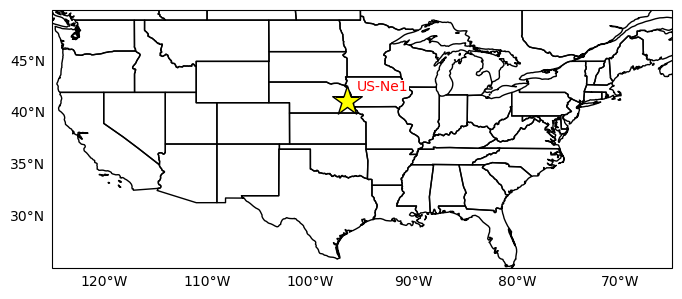

In [98]:
# Plot sites
proj=ccrs.PlateCarree()

# subset CONUS
min_lon, max_lon = -125, -65
min_lat, max_lat = 25, 50

fig, ax = plt.subplots(figsize=(8,6),subplot_kw= {'projection': proj});
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=proj);
ax.add_feature(cfeature.STATES)


site_lat = ameriflux_meta.loc[ameriflux_meta['Site ID'] == site_ID, 'Latitude (degrees)'].values
site_lon = ameriflux_meta.loc[ameriflux_meta['Site ID'] == site_ID, 'Longitude (degrees)'].values

ax.scatter(site_lon,site_lat,
       marker='*', 
       s=500,
       color='yellow',
       edgecolor='black', zorder=3)
ax.annotate(site_ID, (site_lon + 1,site_lat+1),
            color='red',
            bbox=dict(facecolor='white',edgecolor='None', pad=0.1,
                     )

           )

gl = ax.gridlines(draw_labels=True,x_inline=False, y_inline=False,color = "None")
gl.top_labels = False
gl.right_labels = False

In [118]:
NEEplot

:NdOverlay   [Variable]
   :Curve   [time]   (value)

In [119]:
NPPplot

:NdOverlay   [Variable]
   :Curve   [time]   (value)